<a href="https://colab.research.google.com/github/Ak0005-ak/INPRIFMD/blob/main/INPRIFMD_Downsapled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
✅ Ishika's Nevus folder flattened.
✅ All client folders contain the full 9‑class structure.
Found 2949 files belonging to 9 classes.
Found 2575 files belonging to 9 classes.
Found 3132 files belonging to 9 classes.
you distribution: {0: 144, 5: 114, 7: 1000, 3: 109, 8: 1000, 4: 182, 1: 248, 2: 93, 6: 59}
ishika distribution: {4: 182, 2: 1000, 1: 251, 7: 376, 0: 108, 5: 368, 8: 115, 3: 109, 6: 66}
nasih distribution: {3: 1000, 4: 1000, 0: 108, 1: 251, 7: 376, 6: 66, 2: 93, 8: 124, 5: 114}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



--- Federated Round 1 ---
  ▶ Training on you
    you: train=0.7563 | val=0.7286
  ▶ Training on ishika
    ishika: train=0.9053 | val=0.8525
  ▶ Training on nasih
    nasih: train=0.7828 | val=0.6904
  ➜ Round 1 average: train=0.8148 | val=0.7572

--- Federated Round 2 ---
  ▶ Training on you
    you: train=0.8817 | val=0.7887
  ▶ Training on ishika
    ishika: train=0.9433 | val=0.8909
  ▶ Training on nasih
    nasih: train=0.9066 | val=0.7417
  ➜ Round 2 average: train=0.9105 | val=0.8071

--- Federated Round 3 ---
  ▶ Training on you
    you: train=0.9467 | val=0.7851
  ▶ Training on ishika
    ishika: train=0.9793 | val=0.9313
  ▶ Training on nasih
    nasih: train=0.9541 | val=0.7682
  ➜ Round 3 average: train=0.9600 | val=0.8282

--- Federated Round 4 ---
  ▶ Training on you
    you: train=0.9592 | val=0.8270
  ▶ Training on ishika
    ishika: train=0.9885 | val=0.9677
  ▶ Training on nasih
    nasih: train=0.9672 | val=0.8278
  ➜ Round 4 average: train=0.9716 | val=0.8741

---

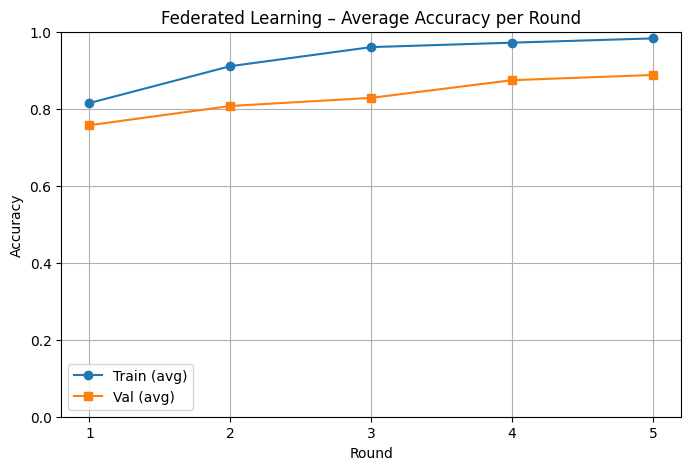


📊 Building confusion matrix from a few random batches...


<Figure size 1000x800 with 0 Axes>

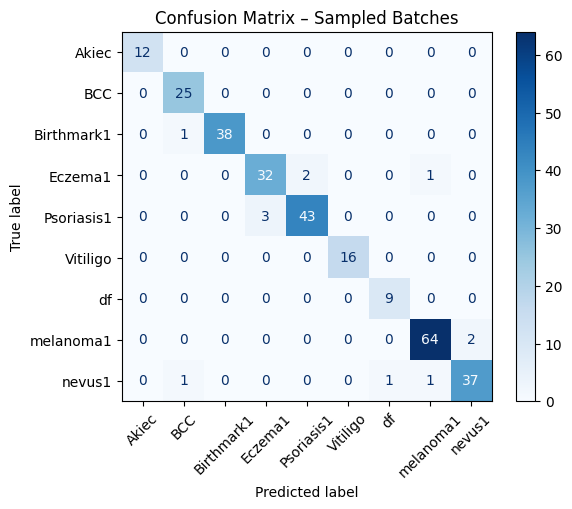


📄 Classification Report:
              precision    recall  f1-score   support

       Akiec       1.00      1.00      1.00        12
         BCC       0.93      1.00      0.96        25
  Birthmark1       1.00      0.97      0.99        39
     Eczema1       0.91      0.91      0.91        35
  Psoriasis1       0.96      0.93      0.95        46
    Vitiligo       1.00      1.00      1.00        16
          df       0.90      1.00      0.95         9
   melanoma1       0.97      0.97      0.97        66
      nevus1       0.95      0.93      0.94        40

    accuracy                           0.96       288
   macro avg       0.96      0.97      0.96       288
weighted avg       0.96      0.96      0.96       288



In [ ]:
# =========================================================
# Federated Learning with Per‑Client Metrics & Confusion Matrix
# =========================================================
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling
from google.colab import drive

# === 1. Mount Google Drive ===
drive.mount('/content/drive')

# === 2. Constants ===
BATCH_SIZE   = 32
IMG_SIZE     = (180, 180)
NUM_CLASSES  = 9
LOCAL_EPOCHS = 5
NUM_ROUNDS   = 5
VAL_SPLIT    = 0.20          # manual split for tf.data

# === 3. Fix nested nevus folders for Ishika (idempotent) ===
nevus_base = '/content/drive/MyDrive/Ishika/Vitiligo/Nevus'
for sub in ['720p', 'masked']:
    src = os.path.join(nevus_base, sub)
    if os.path.exists(src):
        for f in os.listdir(src):
            shutil.move(os.path.join(src, f), nevus_base)
        shutil.rmtree(src)
print("✅ Ishika's Nevus folder flattened.")

# === 4. Class labels (make sure it’s sorted & length == 9) ===
GLOBAL_CLASSES = sorted([
    "Akiec", "BCC", "Birthmark1", "df", "Eczema1",
    "melanoma1", "nevus1", "Psoriasis1", "Vitiligo"
])

# === 5. Client paths ===
CLIENT_DIRS = {
    "you"   : "/content/drive/MyDrive/skin_diseases/all_classes",
    "ishika": "/content/drive/MyDrive/Ishika/Vitiligo",
    "nasih" : "/content/drive/MyDrive/Nasih1"
}

# === 6. Ensure each client has all nine sub‑folders (may be empty) ===
def ensure_class_folders(root_path, class_list):
    for cls in class_list:
        os.makedirs(os.path.join(root_path, cls), exist_ok=True)

for p in CLIENT_DIRS.values():
    ensure_class_folders(p, GLOBAL_CLASSES)
print("✅ All client folders contain the full 9‑class structure.")

# === 7. loads images from library ===
def load_client_data(path):
    return tf.keras.utils.image_dataset_from_directory(
        path,
        label_mode='int',
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_names=GLOBAL_CLASSES,
        shuffle=True
    )

CLIENT_DATASETS = {name: load_client_data(path)
                   for name, path in CLIENT_DIRS.items()}

# === 8. Display class distribution (optional sanity check) ===
def class_distribution(ds):
    counter = Counter()
    for _, y in ds:
        counter.update(y.numpy().tolist())
    return dict(counter)

for n, ds in CLIENT_DATASETS.items():
    print(f"{n} distribution:", class_distribution(ds))

# === 9. Model factory ===
def create_model():
    model = Sequential([
        Rescaling(1/255., input_shape=(*IMG_SIZE, 3)),
        Conv2D(32, 3, activation='relu'), MaxPooling2D(),
        Conv2D(64, 3, activation='relu'), MaxPooling2D(),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# === 10. FedAvg utility ===
def aggregate_weights(weight_list):
    """Simple FedAvg"""
    return [np.mean(ws, axis=0) for ws in zip(*weight_list)]

# === 11. Manual dataset split ===
def split_dataset(ds, val_ratio=VAL_SPLIT):
    total = ds.cardinality().numpy()
    val_sz = int(total * val_ratio)
    return ds.take(total - val_sz), ds.skip(total - val_sz)

# === 12. Federated Training Loop with per‑client metrics ===
global_model = create_model()
round_avg_train, round_avg_val = [], []
per_round_client_metrics = {}      # {round: {client: (train,val)}}

for r in range(1, NUM_ROUNDS + 1):
    print(f"\n--- Federated Round {r} ---")

    global_w = global_model.get_weights()
    collected_weights = []
    client_train_acc, client_val_acc = [], []
    per_round_client_metrics[r] = {}

    # -------- per client --------
    for cname, ds in CLIENT_DATASETS.items():
        print(f"  ▶ Training on {cname}")

        # split
        train_ds, val_ds = split_dataset(ds)

        # local model starts from global weights
        local_model = create_model()
        local_model.set_weights(global_w)

        hist = local_model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=LOCAL_EPOCHS,
            verbose=0
        )

        collected_weights.append(local_model.get_weights())
        tr_acc = hist.history['accuracy'][-1]
        va_acc = hist.history['val_accuracy'][-1]

        client_train_acc.append(tr_acc)
        client_val_acc.append(va_acc)
        per_round_client_metrics[r][cname] = (tr_acc, va_acc)

        print(f"    {cname}: train={tr_acc:.4f} | val={va_acc:.4f}")

    # aggregate & update global
    global_model.set_weights(aggregate_weights(collected_weights))

    # store round averages
    round_avg_train.append(np.mean(client_train_acc))
    round_avg_val.append(np.mean(client_val_acc))

    print(f"  ➜ Round {r} average: train={round_avg_train[-1]:.4f} | val={round_avg_val[-1]:.4f}")

# === 13. Save global model ===
save_path = '/content/drive/MyDrive/FL_model_Derma.keras'
global_model.save(save_path)
print(f"\n✅ Training complete. Global model saved to {save_path}")

# === 14. Plot average accuracy per round ===
plt.figure(figsize=(8,5))
plt.plot(range(1, NUM_ROUNDS+1), round_avg_train, marker='o', label='Train (avg)')
plt.plot(range(1, NUM_ROUNDS+1), round_avg_val, marker='s', label='Val (avg)')
plt.title('Federated Learning – Average Accuracy per Round')
plt.xlabel('Round'); plt.ylabel('Accuracy')
plt.ylim(0,1); plt.grid(True); plt.xticks(range(1, NUM_ROUNDS+1))
plt.legend(); plt.show()

# === 15. Quick confusion matrix on small random subset ===
print("\n📊 Building confusion matrix from a few random batches...")

y_true, y_pred = [], []

for cname, ds in CLIENT_DATASETS.items():
    for i, (x, y) in enumerate(ds.take(3)):      # 3 batches per client
        preds = global_model.predict(x, verbose=0)
        y_true.extend(y.numpy())                 # ground‑truth indices
        y_pred.extend(np.argmax(preds, axis=1))  # predicted indices

# ------------------------------------------------------------------
# Ensure the confusion‑matrix size always matches the 9 GLOBAL_CLASSES
# ------------------------------------------------------------------
label_ids = list(range(len(GLOBAL_CLASSES)))     # [0, 1, …, 8]

cm  = confusion_matrix(y_true, y_pred, labels=label_ids)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=GLOBAL_CLASSES)

plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix – Sampled Batches")
plt.grid(False)
plt.show()

print("\n📄 Classification Report:")
print(classification_report(
        y_true, y_pred,
        labels=label_ids,
        target_names=GLOBAL_CLASSES,
        zero_division=0))

